In [1]:
import numpy as np
import scipy.sparse as sparse
from scipy.io import mmread
from scipy.linalg import expm, norm
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [2]:
# download datasets
dol = mmread('dolphins.mtx').tocsr()
fb = mmread('facebook.mtx').tocsr()
pa = mmread('PA.mtx').tocsr()

In [3]:
# Arnoldi algorithm

# matrix A for which exp(A)b is of interest, n x n
# b initial vector to be used, length n
# m, the produced Krylov subspace will have dimension m

def arnoldi_iteration(A, m: int): 
    b  = np.ones(A.shape[0])  # b default to be 1_n
    
    n = A.shape[0]
    h = np.zeros((m + 1, m)) # to become the m x m upper Hessenberg matrix consisting of the coefficients h_ij
    V = np.zeros((n, m + 1)) # to become the orthonormal basis V_m = [v_1, v_2, ..., v_m]
    v = b / norm(b) # makes v a unit 2-norm vector    
    V[:, 0] = v # use v as the first Krylov vector
    
    for j in range(m):
        w = A @ v  # compute candidate vector
        
        for i in range(j + 1):
            h[i, j] = V[:,i] @ w # h_ij-th element is product of v_i and w
            w = w - h[i, j] * V[:, i] # modified Gram-Schmidt
            
        h[j + 1, j] = norm(w)
        
        zero = 1e-12 # small value used as h_ij = 0 threshold
        if h[j + 1, j] > zero: # if nonzero add v to the basis
            v = w / h[j + 1, j]
            V[:, i + 1] = v
        else: 
            return V, h 
        # print('step',j,'out of',m) # to check how far along algorithm is for larger n
    return V, h

In [4]:
# get Vm and Hm from output
def get_m(Vm1,Hm1,m):
    Vm, Hm = sparse.csc_matrix(Vm1[:,0:m]), sparse.csc_matrix(Hm1[0:m,0:m])
    return Vm, Hm

In [5]:
# get approximation from arnoldi result
def a_approximation(A, Vm, Hm, m):
    # get beta = ||v||_2
    b = np.ones(A.shape[0])
    beta = norm(b)

    # get unit vector
    e1 = np.zeros((m,1))
    e1[0] = 1
    e1 = sparse.csc_matrix(e1)
    
    X = beta * Vm @ expm(Hm) @ e1
    return X

In [6]:
########## TIMINGS

In [7]:
########## DOLPHIN ERROR PLOT

# compute arnoldi for m = 62

# using Vm,Hm for m = 1,...,62 calculate error 

# plot error as m increases

In [8]:
m = 62

V, H = arnoldi_iteration(dol, m)
Vm, Hm = get_m(V,H,m)

In [9]:
b = np.ones(dol.shape[0])
expab = expm(dol) @ sparse.csc_matrix(b.reshape(dol.shape[0],1))

C:\Users\bethm\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:310: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\bethm\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:208: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [10]:
approx = a_approximation(dol, Vm, Hm, m)

In [11]:
errors = []
mVals = list(range(1,63))

for i in range(1,63):
    Vm, Hm = get_m(V,H, i)
    approx = a_approximation(dol, Vm, Hm, i)
    
    error =  norm(expab.toarray() - approx.toarray())/norm(expab.toarray())
    errors.append(error)

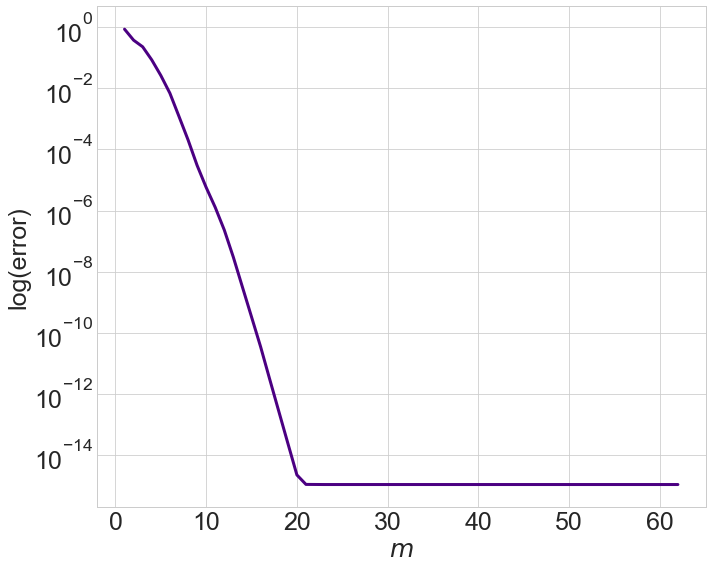

In [12]:
# plot
plt.style.use('seaborn-whitegrid') 
n = 25
fig, ax = plt.subplots(figsize = (10,8))
fig = plt.semilogy(mVals,errors, linewidth = 3.0, color ='indigo')
plt.xlabel(r'$m$', fontsize = n)
plt.ylabel(r'log(error)', fontsize = n)
plt.yticks(fontsize = n)
plt.xticks(fontsize = n)
plt.tight_layout()
plt.savefig('./images/dol_error_plot.pdf')
plt.show()

In [33]:
# calculate expab centrality from both methods
print('Arnoldi method found central-most node is',approx.argmax()+1,'\nScaling and squaring found central-most node is',expab.argmax()+1)

Arnoldi method found central-most node is 1913 
Scaling and squaring found central-most node is 1913


In [13]:
########## FACEBOOK ERROR PLOT

In [14]:
m = 100

V, H = arnoldi_iteration(fb, m)
Vm, Hm = get_m(V,H,m)

In [15]:
start = timer()
b = np.ones(fb.shape[0])
expFB = expm(fb)
expab = expFB @ sparse.csc_matrix(b.reshape(fb.shape[0],1))
end = timer()

C:\Users\bethm\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:310: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\bethm\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:208: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [16]:
expFB_time = end - start
print(expFB_time)

1587.5899586


In [17]:
approx = a_approximation(fb, Vm, Hm, m)

In [18]:
m= 100

errors = []
mVals = list(range(1,m+1))

for i in range(1,m+1):
    Vm, Hm = get_m(V,H, i)
    approx = a_approximation(fb, Vm, Hm, i)
    
    error =  norm(expab.toarray() - approx.toarray())/norm(expab.toarray())
    errors.append(error)

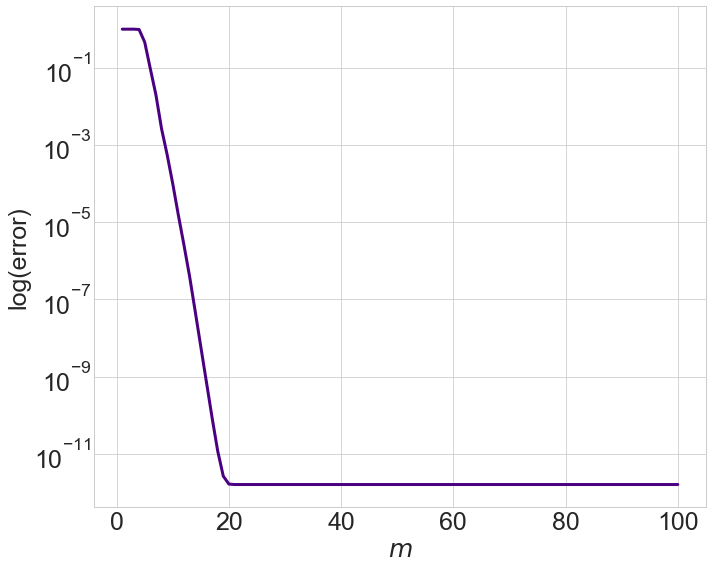

In [19]:
# plot
plt.style.use('seaborn-whitegrid') 
n = 25
fig, ax = plt.subplots(figsize = (10,8))
fig = plt.semilogy(mVals,errors, linewidth = 3.0, color ='indigo')
plt.xlabel(r'$m$', fontsize = n)
plt.ylabel(r'log(error)', fontsize = n)
plt.yticks(fontsize = n)
plt.xticks(fontsize = n)
plt.tight_layout()
plt.savefig('./images/fb_error_plot.pdf')
plt.show()

In [33]:
# calculate expab centrality from both methods
print('Arnoldi method found central-most node is',approx.argmax()+1,'\nScaling and squaring found central-most node is',expab.argmax()+1)

Arnoldi method found central-most node is 1913 
Scaling and squaring found central-most node is 1913


In [24]:
# PA checking how few iterations it takes to land onfinal central-most node
m = 20

mVals = list(range(1,21))
V,H = arnoldi_iteration(pa,m)

nodes =[]

for i in range(1,21):
    Vm, Hm = get_m(V,H, i)
    pa_approx = a_approximation(pa, Vm, Hm, i)
    nodes.append(pa_approx.argmax())
    
nodes

[0,
 674502,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932,
 847932]

In [26]:
# solution found in 3, how long does this take?

for i in range(5):
    start = timer()
    V,H = arnoldi_iteration(pa,3)
    Vm, Hm = get_m(V,H, 3)
    pa_approx = a_approximation(pa, Vm, Hm, 3)
    end = timer()
    
print((end - start)/5)

0.11267838000203483


In [40]:
# fb checking how few iterations it takes to land on final central-most node
m = 20

mVals = list(range(1,21))
V,H = arnoldi_iteration(fb,m)

nodes =[]

for i in range(1,21):
    Vm, Hm = get_m(V,H, i)
    fb_approx = a_approximation(fb, Vm, Hm, i)
    nodes.append(fb_approx.argmax())
    
nodes

[0,
 107,
 2347,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912]

In [43]:
# dol checking how few iterations it takes to land on final central-most node
m = 20

mVals = list(range(1,21))
V,H = arnoldi_iteration(dol,m)

nodes =[]

for i in range(1,21):
    Vm, Hm = get_m(V,H, i)
    dol_approx = a_approximation(dol, Vm, Hm, i)
    nodes.append(dol_approx.argmax())
    
nodes

[0, 14, 37, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]

In [20]:
########## PA TIMINGS BAR CHART 